# Learning phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [3]:
games_details = pd.read_csv('../dataset/complete_dataset.csv', low_memory=False)
cols_to_drop = [col for col in games_details.columns if -1 in games_details[col].values]
games_details.drop(columns = cols_to_drop, inplace=True)
games_details.head()

,GAME_ID,TEAM_ID,PLAYER_ID,FG3M,OPPOSING_TEAM,LOCATION,SEASON
0,22200477,1610612759,1629641,0.0,1610612740,Away,2022
1,22200477,1610612759,1631110,2.0,1610612740,Away,2022
2,22200477,1610612759,1627751,0.0,1610612740,Away,2022
3,22200477,1610612759,1630170,1.0,1610612740,Away,2022
4,22200477,1610612759,1630200,1.0,1610612740,Away,2022


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# label encoder e non one-hot encoding per evitare di aumentare di molto
# dimensionalità del dataset e perché le date e simili hanno effettivamente un ordine

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
games_details = games_details.drop(columns=['GAME_ID'])
games_details = games_details.sample(frac=0.1)

categorical_columns = games_details.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
games_details[list(categorical_columns)] = games_details[list(categorical_columns)].apply(label_encoder.fit_transform)

games_details = games_details.dropna()
games_details = games_details.reset_index(drop=True)

X = games_details.loc[:, games_details.columns != 'FG3M']
y = games_details['FG3M']

reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])

In [6]:
num_folds = 8

num_features = X.shape[1]
p = int(np.ceil(num_features / 3))
rf_param_grid = {
    'n_estimators': [50, 100, 500],
    'max_features': ['sqrt', 'log2', p] 
}

rf_regressor = RandomForestRegressor()
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X) # questo non sarebbe legittimo

grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
print(rf_best_params)

{'max_features': 'sqrt', 'n_estimators': 500}


In [7]:
rf_kfolds = KFold(n_splits=num_folds, shuffle=True)
gini_importances = pd.DataFrame(columns=X.columns)

for fold, (train_idx, test_idx) in enumerate(rf_kfolds.split(X)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf_regressor = RandomForestRegressor(n_estimators = rf_best_params['n_estimators'], max_features = rf_best_params['max_features'])
    
    rf_regressor.fit(X_train, y_train)
    
    y_pred = rf_regressor.predict(X_test)
    
    current_rf_mae = mean_absolute_error(y_test, y_pred)
    current_rf_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse]

    importances = rf_regressor.feature_importances_
    gini_importances.loc[fold] = importances

In [8]:
dummy_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in dummy_kfolds.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X_train, y_train)
    
    y_dummy_pred = dummy_regressor.predict(X_test)

    current_dummy_mae = mean_absolute_error(y_test, y_dummy_pred)
    current_dummy_mse = mean_squared_error(y_test, y_dummy_pred)

    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse]

In [9]:
knn_param_grid = {
    'n_neighbors': [1, 5, 10],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, knn_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

knn_best_params = grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 10, 'p': 1}


In [10]:
knn_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in knn_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors = knn_best_params['n_neighbors'], p = knn_best_params['p'])
    knn_regressor.fit(X_train, y_train)
    
    y_pred = knn_regressor.predict(X_test)
    
    current_knn_mae = mean_absolute_error(y_test, y_pred)
    current_knn_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse]

    Model       MAE       MSE
0      RF  0.806005  1.273774
1      RF  0.811442  1.323882
2      RF  0.794527  1.249118
3      RF  0.808247  1.270466
4      RF  0.801017  1.270713
5      RF  0.782284  1.253707
6      RF  0.809379  1.316990
7      RF  0.792429  1.233862
8   DUMMY  0.932639  1.532237
9   DUMMY  0.929964  1.522596
10  DUMMY  0.927021  1.476485
11  DUMMY  0.935739  1.508720
12  DUMMY  0.940653  1.554497
13  DUMMY  0.946490  1.546013
14  DUMMY  0.924129  1.479253
15  DUMMY  0.939674  1.555291
16    KNN  0.916502  1.547182
17    KNN  0.929798  1.602569
18    KNN  0.935437  1.576466
19    KNN  0.930156  1.588398
20    KNN  0.927641  1.611622
21    KNN  0.941597  1.612448
22    KNN  0.939665  1.642658
23    KNN  0.924549  1.530242


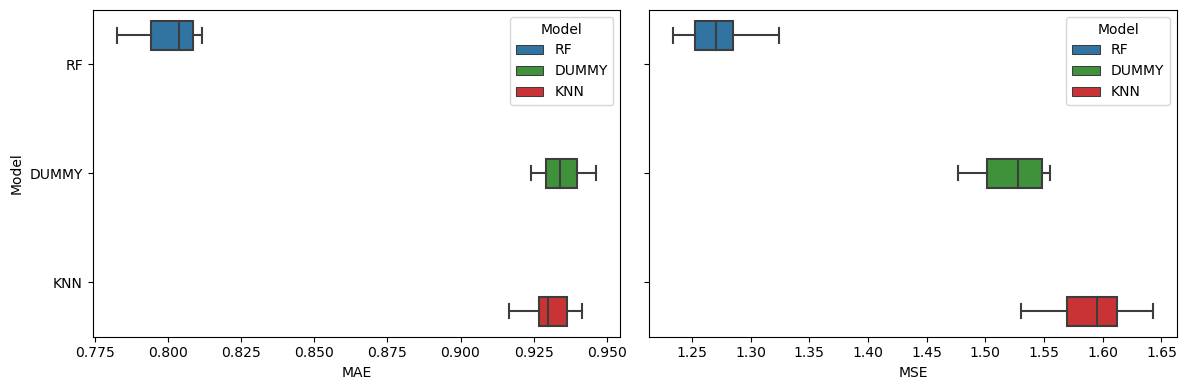

In [11]:
print(reg_metrics)
fig, axs = plt.subplots(1, 2, figsize= (12, 4))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", hue = 'Model', ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", hue = 'Model', ax=axs[1], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

    TEAM_ID  PLAYER_ID  OPPOSING_TEAM  LOCATION    SEASON
0  0.168605   0.396567       0.267689  0.039624  0.127515
1  0.177518   0.377153       0.273609  0.041480  0.130240
2  0.179192   0.377109       0.272213  0.041493  0.129993
3  0.176787   0.376472       0.273139  0.041619  0.131983
4  0.177402   0.375341       0.275402  0.040690  0.131165
5  0.168572   0.396635       0.266771  0.040471  0.127552
6  0.180535   0.375026       0.276129  0.040530  0.127780
7  0.178532   0.374638       0.274558  0.041188  0.131084


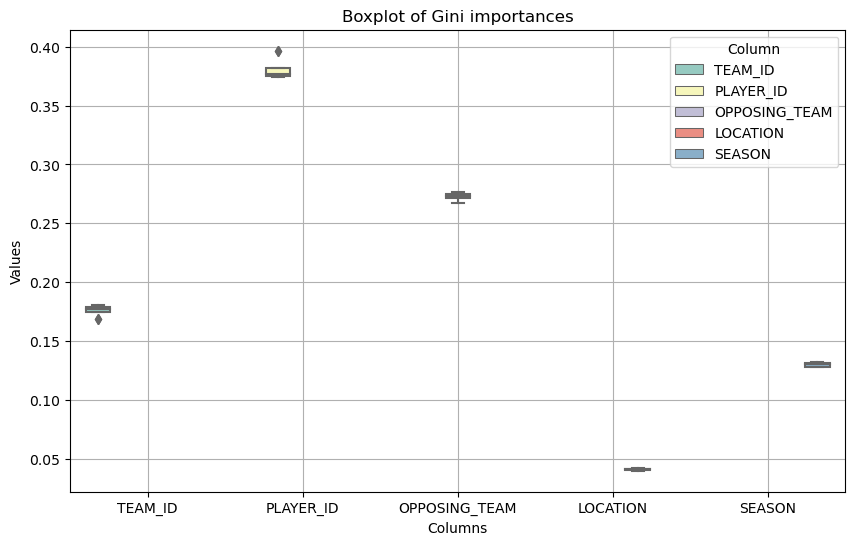

In [12]:
print(gini_importances)
melted_gini = gini_importances.melt(var_name='Column')

# Create boxplot with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Column', y='value', data=melted_gini, hue='Column', palette='Set3')

plt.title('Boxplot of Gini importances')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Column')
plt.grid(True)
plt.show()